<a href="https://colab.research.google.com/github/nishantkapps/aiml-projects/blob/main/DenguePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import os
from keras import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [ ]:
dlltrn = pd.read_csv('/content/drive/MyDrive/datasets/dengue_labels_train.csv')
dlftrn = pd.read_csv('/content/drive/MyDrive/datasets/dengue_features_train.csv')
dlftst = pd.read_csv('/content/drive/MyDrive/datasets/dengue_features_test.csv')
dlsub = pd.read_csv('/content/drive/MyDrive/datasets/dengue_submission_format.csv')

In [ ]:
pd.options.display.max_columns = None

In [ ]:
data = pd.concat([dlftrn,dlltrn.iloc[:,-1]],axis=1)

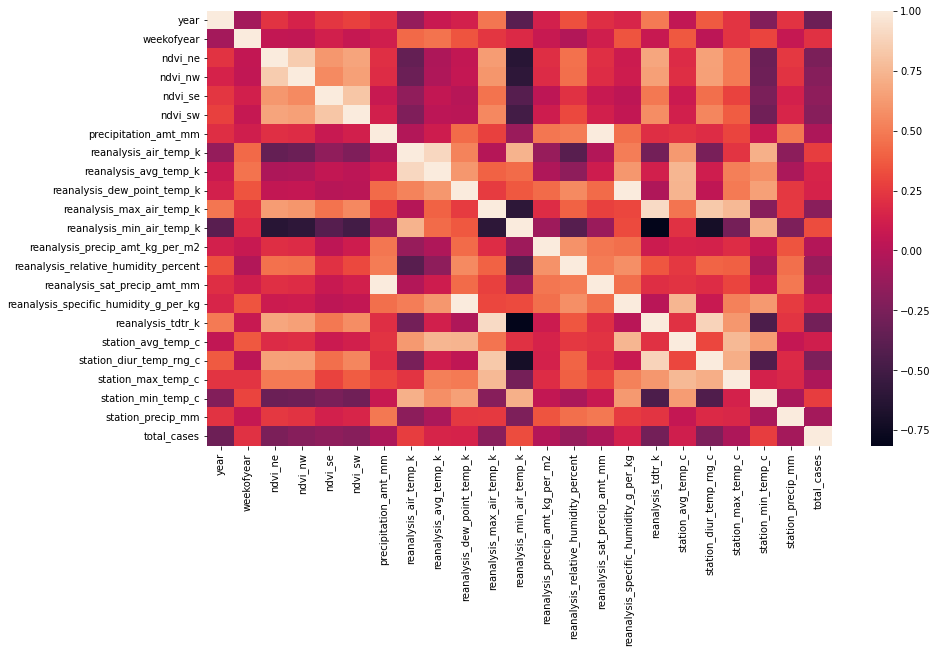

In [ ]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr())

In [ ]:
data.shape

(1456, 25)

In [ ]:
# Fill missing values in columns having more than 10 missing values with median of the column
data['ndvi_ne'] = data['ndvi_ne'].fillna(data['ndvi_ne'].median())
data['ndvi_nw'] = data['ndvi_nw'].fillna(data['ndvi_nw'].median())
data['ndvi_se'] = data['ndvi_se'].fillna(data['ndvi_se'].median())
data['ndvi_sw'] = data['ndvi_sw'].fillna(data['ndvi_sw'].median())
data['station_avg_temp_c'] = data['station_avg_temp_c'].fillna(data['station_avg_temp_c'].median())
data['station_diur_temp_rng_c'] = data['station_diur_temp_rng_c'].fillna(data['station_diur_temp_rng_c'].median())
data['precipitation_amt_mm'] = data['precipitation_amt_mm'].fillna(data['precipitation_amt_mm'].median())
data['reanalysis_sat_precip_amt_mm'] = data['reanalysis_sat_precip_amt_mm'].fillna(data['reanalysis_sat_precip_amt_mm'].median())
data['station_max_temp_c'] = data['station_max_temp_c'].fillna(data['station_max_temp_c'].median())
data['station_min_temp_c'] = data['station_min_temp_c'].fillna(data['station_min_temp_c'].median())
data['station_precip_mm'] = data['station_precip_mm'].fillna(data['station_precip_mm'].median())

In [ ]:
# After fillna, only those columns having 10 missing values are left, these rows can all be deleted
data.dropna(inplace=True)

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
data.shape

(1446, 25)

In [ ]:
data.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [ ]:
x = data.iloc[:,4:-1].values
y = data.iloc[:,-1].values

In [ ]:
x

array([[1.226000e-01, 1.037250e-01, 1.984833e-01, ..., 2.940000e+01,
        2.000000e+01, 1.600000e+01],
       [1.699000e-01, 1.421750e-01, 1.623571e-01, ..., 3.170000e+01,
        2.220000e+01, 8.600000e+00],
       [3.225000e-02, 1.729667e-01, 1.572000e-01, ..., 3.220000e+01,
        2.280000e+01, 4.140000e+01],
       ...,
       [2.470571e-01, 1.460571e-01, 2.503571e-01, ..., 3.220000e+01,
        1.920000e+01, 7.400000e+00],
       [3.339143e-01, 2.457714e-01, 2.788857e-01, ..., 3.120000e+01,
        2.100000e+01, 1.600000e+01],
       [2.981857e-01, 2.329714e-01, 2.742143e-01, ..., 3.370000e+01,
        2.220000e+01, 2.040000e+01]])

In [ ]:
# Scaling & transforming the data
ss = StandardScaler()
xscl = ss.fit_transform(x)

In [ ]:
# Split the data into test & train
x_train, x_test, y_train, y_test = train_test_split(xscl,y,random_state=12,train_size=0.7)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1012, 20)
(434, 20)
(1012,)
(434,)


In [ ]:
# Fit the model
xgb = XGBRegressor(reg_alpha=200, learning_rate=0.02)
xgb.fit(x_train,y_train)
y_predtr = xgb.predict(x_train)
y_predts = xgb.predict(x_test)
print('Train MSE :',mean_absolute_error(y_predtr,y_train))
print('Test MSE :',mean_absolute_error(y_predts,y_test))

[15:43:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MSE : 16.353607211895138
Test MSE : 16.226404878950337


In [ ]:
# Fit the model - Linear Regression
lreg = LinearRegression()
lreg.fit(x_train,y_train)
y_pred = lreg.predict(x_test)
mean_squared_error(y_pred,y_test)

1355.6571658973749

In [ ]:
# Fit the model - Ridge Regression
rreg = Ridge(alpha=100)
rreg.fit(x_train,y_train)
y_pred = rreg.predict(x_test)
mean_squared_error(y_pred,y_test)

1346.009989679611